
# Earthquake Magnitude Prediction with Dense Neural Network

This notebook demonstrates how to build and train a Dense Neural Network (DNN)
using TensorFlow/Keras to predict earthquake magnitude from structured features
like latitude, longitude, depth, time, etc.


# 1. Setup and Data Loading

In [59]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam


In [60]:
from google.colab import drive

# This will prompt you to authorize access
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [61]:

# Load your cleaned/preprocessed dataset
# Replace the path with your dataset location
df = pd.read_csv('/content/drive/MyDrive/DLlabs/Seismic-GNN-Prediction-main/data/processed/earthquakes_cleaned.csv')


In [62]:
# Display first few rows
print("\n📊 First 5 Events:")
df.head()


📊 First 5 Events:


,event_id,time,year,month,day,hour,minute,day_of_week,day_of_year,timestamp,...,has_uncertainty,time_uncertainty_sec,azimuthal_gap_deg,stations_used,min_station_distance_deg,description,hour_sin,hour_cos,month_sin,month_cos
0,query?eventid=ci37301704&format=quakeml,2015-01-04 03:18:09.480,2015,1,4,3,18,6,4,1420341489,...,True,NaN,NaN,106.0,NaN,"14km N of Castaic, CA",0.707107,0.707107,0.5,0.866025
1,query?eventid=nn00481243&format=quakeml,2015-01-04 09:56:43.113,2015,1,4,9,56,6,4,1420365403,...,True,NaN,NaN,5.0,0.141,"43 km E of Fort Bidwell, California",0.707107,-0.707107,0.5,0.866025
2,query?eventid=nn00475344&format=quakeml,2015-01-04 20:08:14.199,2015,1,4,20,8,6,4,1420402094,...,True,NaN,NaN,5.0,0.136,"42 km E of Fort Bidwell, California",-0.866025,0.500000,0.5,0.866025
3,query?eventid=nn00475380&format=quakeml,2015-01-05 01:47:21.986,2015,1,5,1,47,0,5,1420422441,...,True,NaN,NaN,5.0,0.145,"42 km E of Fort Bidwell, California",0.258819,0.965926,0.5,0.866025
4,query?eventid=nn00475453&format=quakeml,2015-01-05 15:35:50.158,2015,1,5,15,35,0,5,1420472150,...,True,NaN,NaN,7.0,0.133,"42 km E of Fort Bidwell, California",-0.707107,-0.707107,0.5,0.866025


In [63]:
# Convert time to datetime
df['time'] = pd.to_datetime(df['time'])

# Sort by time (critical for temporal features)
df = df.sort_values('time').reset_index(drop=True)

print(f"Loaded {len(df)} earthquake events")
print(f"Date range: {df['time'].min()} to {df['time'].max()}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nData shape: {df.shape}")
print(f"\nTarget variable (magnitude) stats:")
print(df['magnitude'].describe())

Loaded 1707 earthquake events
Date range: 2015-01-04 03:18:09.480000 to 2024-12-29 00:21:10.260000

Columns: ['event_id', 'time', 'year', 'month', 'day', 'hour', 'minute', 'day_of_week', 'day_of_year', 'timestamp', 'latitude', 'longitude', 'depth_km', 'magnitude', 'magnitude_type', 'horizontal_uncertainty_km', 'depth_uncertainty_km', 'has_uncertainty', 'time_uncertainty_sec', 'azimuthal_gap_deg', 'stations_used', 'min_station_distance_deg', 'description', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos']

Data shape: (1707, 27)

Target variable (magnitude) stats:
count    1707.000000
mean        3.892795
std         0.418079
min         3.500000
25%         3.600000
50%         3.770000
75%         4.060000
max         7.100000
Name: magnitude, dtype: float64


# 2. Preprocessing Data

In [64]:

# --- Preprocessing ---
# Convert time to datetime
df['time'] = pd.to_datetime(df['time'])

# Extract numeric time features
df['year'] = df['time'].dt.year
df['month'] = df['time'].dt.month
df['day'] = df['time'].dt.day
df['hour'] = df['time'].dt.hour
df['minute'] = df['time'].dt.minute
df['day_of_week'] = df['time'].dt.dayofweek
df['day_of_year'] = df['time'].dt.dayofyear
df['timestamp'] = df['time'].astype(int) // 10**9  # convert to smaller scale

# Replace with your actual feature column names
features = [ 'year', 'month', 'day', 'hour', 'minute', 'day_of_week', 'day_of_year', 'timestamp', 'latitude', 'longitude', 'depth_km', 'magnitude', 'horizontal_uncertainty_km', 'depth_uncertainty_km', 'time_uncertainty_sec', 'azimuthal_gap_deg', 'stations_used', 'min_station_distance_deg', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos']
X = df[features]


In [65]:
# Remove NaNs/Infs
X = X.fillna(0)
X = X.replace([np.inf, -np.inf], 0)

# Target
y = df['magnitude'].fillna(df['magnitude'].median())

# 3. Scale Data

In [66]:
# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

In [67]:

# Define DNN architecture
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)  # Regression output
])

# Compile model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,585 (14.00 KB)

 Trainable params: 3,585 (14.00 KB)

 Non-trainable params: 0 (0.00 B)

In [68]:

# Train the model
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    verbose=1
)


Epoch 1/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 12.2785 - mae: 3.3917 - val_loss: 1.4801 - val_mae: 1.0852
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8444 - mae: 0.7533 - val_loss: 0.4739 - val_mae: 0.5157
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3579 - mae: 0.4735 - val_loss: 0.3121 - val_mae: 0.4139
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2466 - mae: 0.3889 - val_loss: 0.2487 - val_mae: 0.3664
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2029 - mae: 0.3495 - val_loss: 0.2157 - val_mae: 0.3399
Epoch 6/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1740 - mae: 0.3254 - val_loss: 0.1922 - val_mae: 0.3206
Epoch 7/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1522 - mae: 0.3070 - val_loss: 0.1699 - val_mae: 0.3012
Epoch 8/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1330 - mae: 0.2798 - val_loss: 0.1586 - val_mae: 0.2856
Epoch 9/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1086 - mae:

In [69]:
# --- Predictions ---
y_pred = model.predict(X_test).flatten()

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


In [70]:
# --- Check for NaNs ---
print("y_test shape:", y_test.shape)
print("y_pred shape:", y_pred.shape)
print("Sample actual:", y_test[:10].values)
print("Sample predicted:", y_pred[:10])

y_test shape: (342,)
y_pred shape: (342,)
Sample actual: [3.74 6.2  3.98 3.74 4.   3.54 3.57 3.52 3.73 4.2 ]
Sample predicted: [3.7121375 6.6176867 3.8893404 3.4496691 3.9511893 3.5637863 3.555289
 3.5104196 3.456916  4.166505 ]


In [71]:
# --- Metrics ---
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

In [72]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Test MAE: {mae:.3f}, RMSE: {rmse:.3f}, R²: {r2:.3f}")

Test MAE: 0.109, RMSE: 0.156, R²: 0.852


In [74]:
tolerance = 0.5  # ±0.5 magnitude
correct = np.abs(y_test - y_pred) <= tolerance
accuracy_percent = np.mean(correct) * 100
print(f"Custom accuracy (within ±{tolerance}): {accuracy_percent:.2f}%")

Custom accuracy (within ±0.5): 98.54%


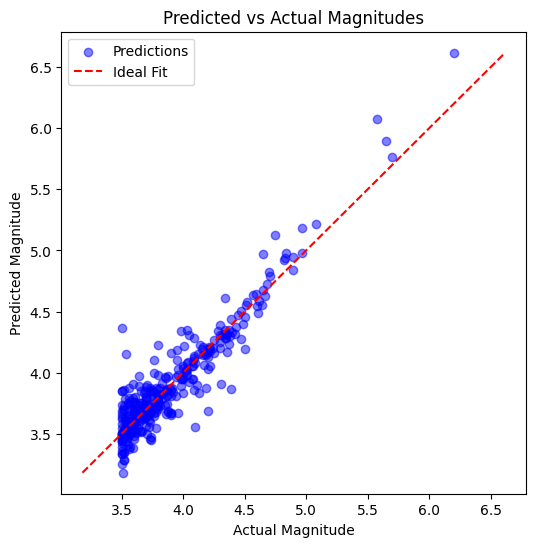

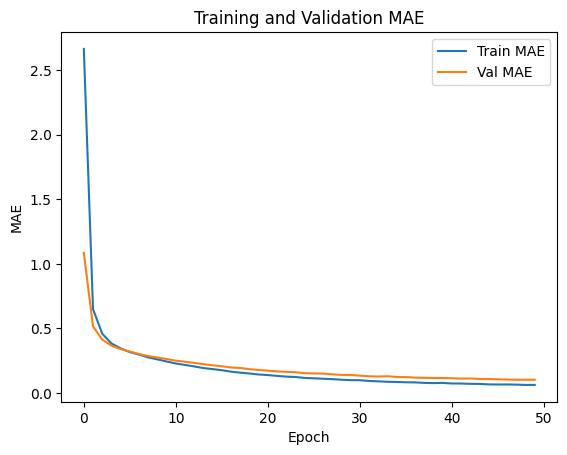

In [75]:
# --- Scatter plot: Predicted vs Actual ---
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.5, c='blue', label="Predictions")
plt.xlabel("Actual Magnitude")
plt.ylabel("Predicted Magnitude")
plt.title("Predicted vs Actual Magnitudes")
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label="Ideal Fit")
plt.legend()
plt.show()

# --- Training History ---
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.title('Training and Validation MAE')
plt.show()